<a href="https://colab.research.google.com/github/ferit-osirv/lab7/blob/main/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7 -  Intro to Convolutional Neural Networks

Ove laboratorijske vježbe se rješavaju u Google Colabu i spremaju na GitHub repozitorij koji je povezan na GitHub Classroom.

## Kako riješiti zadatke?

1. Prihvatite zadatak putem Google Classroom linka koji ćete dobiti. Google Classroom će kreirati repozitorij na vašem računu.
2. Uđite u novokreiran repozitorij na vašem računu i kliknite na **.ipynb** datoteku, zatim kliknite **Open in Colab**.
3. Zadatke rješavate u Google Colabu.

## Kako spremiti (predati) zadatke?

1. Unutar **Google Colaba** kliknite na **Open settings** kotačić u gornjem desnom kutu.
2. Kliknite na **GitHub** tab i odaberite kvačicu za **Access private repositories and organizations**.
3. Otvorit će se novi prozor da dodate pristup GitHubu. Kod **ferit-osirv** kliknite **Grant**.  
4. Spremite i izađite iz postavki.


5. Kliknite na **File > Save a copy in GitHub**.
6. Odaberite kreiran repozitorij labosa **koji uključuje vaše ime**.

> *Napomena:* Korake 1-4 morate napraviti samo prvi put.

# Introduction

Convolutional neural networks (CNNs) are one of the largest revolutions in the computer vision field. They are the state of the art (SOTA) solution for problems like object detection, handwriting recognition, face recognition, and many other image processing tasks.

Traditional methods are still used for specific tasks and as preprocessing steps for CNNs, so don't forget everything you've learned so far. :)

You already used convolutions many times in these labs. In lab2 you wrote your own convolution code. In lab3 you used median filtering, a convolution with a specific kernel to blur the image. In lab4 you used a blur filter.

Depending on the used kernel, convolutions can achieve all kinds of different things: Show specific features like edges and corners, show and remove textures, etc.

Traditionally, when someone is working on an image processing task they would hand-select the kernel used in the convolution.

CNNs work similarly but take it all one step further. Instead of manually convolving the image with known kernels, in deep learning we let the network learn the kernels it's using. CNNs have multiple layers, in each layer, they perform lots and lots of convolutions with different kernels in parallel. Each layer's output is used as input for the next layer. By doing this, a CNN can learn more-and-more complex features deeper in the network. At first, it can detect lines and corners, in the later layers, it can combine lines to detect more complex shapes, and so on.

Follow along this notebook to find out how CNNs work.

## PyTorch and neural networks

For this lab, you'll use PyTorch, one of the most popular deep learning libraries to implement a convolutional neural network from scratch. For simple problems, you can use tools like [fastai](https://docs.fast.ai) which can automate a lot of this process for you. Still, it's good to be familiar with what lies beneath tools like that.

Begin by importing PyTorch and the TorchVision library, which has useful functions to work with images.

In [ ]:
import torch
import torchvision

Next, we'll declare a couple of properties. Don't worry about these just yet.

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

# Preparing our data

To train a neural network, we first need a lot of data. Neural networks learn by looking at example input images and their correct output. In your case that will be a bunch of handwritten digits and their correct translation into text.

You can look at a neural network as a math function, mapping inputs into outputs. By knowing the correct solution during training, a neural network can adjust what it does inside the function so that its output matches the correct solution.

For this problem, you'll use a popular dataset of handwritten digits called MNIST. Torchvision already includes a function to download the dataset.

You'll apply a transformation to each image. First, you'll convert the images to PyTorch Tensors. Tensors are _very_ similar to NumPy arrays, so you're already fairly familiar with them.

The other transformation you'll apply is normalization. Since neural networks work by multiplying and adding together a bunch of numbers, the absolute values of those numbers matter a lot. Multiplying 0.001 a bunch of times will give you a very small number at the end, making it very hard to work with. Similarly, multiplying huge numbers can be unstable too. It's best to map CNN inputs into a range of [-0.5, 0.5], making sure they're centered around 0. That's what the Normalize transform does.

You'll create two datasets, one for training and one for testing. It's very important that you do this step: You can't verify that your model works if you train and test the model on the same data, since it can in some cases learn to reproduce correct outputs on the training data by memorization, not understanding.

In [ ]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_data = torchvision.datasets.MNIST('/files/', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

test_data = torchvision.datasets.MNIST('/files/', train=False,
                                        download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 103463861.67it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65408042.02it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28103326.44it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1531392.99it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



You also create a DataLoader for your dataset. NNs are usually trained in batches of inputs. Training the network one by one input is far too slow, but we also can't train on all of the inputs. That's why we specify a batch size of 64: During each training iteration, the network will receive 64 images. The DataLoader class does the batching for us.

Let's grab the first batch from the testing DataLoader:

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

Your example data has the following shape: (n_batches, n_channels, width, height). The batch size is specified when creating the DataLoader. The images themselves are very small and grayscale, which explains why they only have one channel.

**Question 1:** What is the shape of the _training_ loader's first batch?

Type your answer here.
Shape of _training loaders first batch is the same as the thest loader ([1000, 1, 28, 28])

Next, let's use matplotlib to plot a few examples of the images:

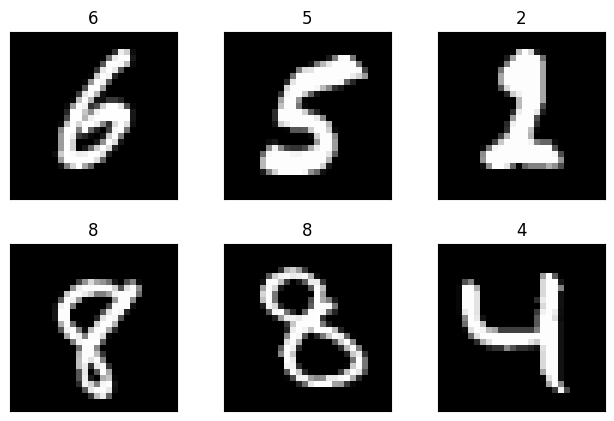

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(example_targets[i].item())
  plt.xticks([])
  plt.yticks([])

**Question 2**: You were tasked with training a NN for handwritten digit detection using this dataset. You will perform the detection on scanned (regular A4 printer) papers where the digits were typed inside boxes with a blue pen. Which preprocessing steps would you perform on your own inputs, knowing the network was trained on images like the ones above?

Type your answer here.

mage Resizing:

Steps that we need to do are: normalization, grayscale conversion, noise reduction, thresholding and edge detection.

# CNN architecture

Now it's time to build the network. A CNN usually consists of convolutional layers, i.e. NN layers that perform a convolution on the input matrix and return the convolved matrix as output. You'll use two of these layers. You'll then use a dropout layer, which just randomly disables half of the features to prevent the network from memorizing the training dataset. Finally, you'll use two layers to combine all of the convolution results into just 10 numbers, the probability for each digit. Exactly how those layers are combined (whether they are summed, how much each layer contributes to the result for each digit, etc.) will be learned during training.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In the `__init__` of the class you create all the necessary layer objects that the network will use, but you just add them as properties, they don't do anything yet.

The `forward()` method is called every time the network receives a new output. `forward()`'s job is to calculate the output from the network and return it. What you'll do is pass the input to the first layer, and then pass the output of that layer to the next one, all the way until you get your 10 numbers. Finally, you'll use `log_softmax()` on those 10 numbers just to map them to probabilities from 0 to 1, and make sure they all add up to 1. There's no magic here, just high-school level math. :)

Next, we'll instantiate the network on the GPU:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Net().to(device)

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Along with the network, we also instantiate an optimizer. The optimizer is in charge of training the network, more on that in the next section:

# Training

Now that you have a network, it's time to train it. Explained at a very high level, training works by first giving the model an input image, and the model gives us a resulting prediction in the form of 10 numbers, a probability for each digit. Naturally, this prediction is basically random at first. We then compare the model's output with the actual value (for the digit 3, it would be `[0, 0, 0, 1, 0, 0, ...]` - the probability of 1 on the 4th index of the array). The comparison is done with a function called the **loss** function, which measures how bad the model is. During training, our job is to **minimize the loss function**.

To minimize the loss, we simply need to shift the parameters of the network so that the loss goes down. We can know this if we calculate the gradient of the loss. You already know from math that the gradient measures the speed and direction of change. By taking the gradient of the loss function, we know if we need to increase or decrease our parameters to get a decrease of the loss.

That's where the optimizer comes in. PyTorch includes a bunch of different algorithms to minimize the loss function. They are in charge of increasing or decreasing the network's parameters so that the loss goes down. That's why the optimizer above receives the network's parameters: It needs to be able to change them.

The following function will be called during each **epoch** of training. An epoch is _one iteration through the whole training dataset_. In real-world applications, we use 100s of epochs, but in this example, only 3 are enough to achieve good results.

In [ ]:
def train(epoch):
  # Set the network in training mode. This doesn't really do much, it's just
  # a flag that we set.
  network.train()
  # for each training batch in the train loader
  for batch_idx, data in enumerate(train_loader):
    # grab the training batch and copy it to the GPU
    # image - the input image
    # target - the correct output
    image, target = data[0].to(device), data[1].to(device)
    # first, set all gradients to zero
    optimizer.zero_grad()
    # calculate a prediction from the model
    output = network(image)
    # calculate the loss for this batch
    loss = F.nll_loss(output, target)
    # calculate the gradient of each part of the network,
    # and store it inside the tensors in the network
    loss.backward()
    # then use those gradients to nudge paramers so that the loss goes down
    optimizer.step()

    # this part doesn't perform training, it just gives us a progress report
    # and periodically saves our training result
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

Once we're done with training, we're ready to test our network. We'll do this by giving the model our test data and taking all the predictions. We then compare the model's predictions with known correct outputs to calculate the model's accuracy.

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data in test_loader:
      image, target = data[0].to(device), data[1].to(device)
      output = network(image)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      # our output gives us a probability for each digit, so we take the one
      # with the highest probability as our predicted digit
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

So far you only declared functions, it's time to use them. You'll set up a couple of variables to track the loss so that you can plot it later, and then train for three epochs, and test the model at the end of each epoch.

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-6-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3141, Accuracy: 638/10000 (6%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332006
Train Epoch: 1 [200/60000 (11%)]	Loss: 2.053115
Train Epoch: 1 [400/60000 (21%)]	Loss: 1.146453
Train Epoch: 1 [600/60000 (32%)]	Loss: 0.730658
Train Epoch: 1 [800/60000 (43%)]	Loss: 0.633650
Train Epoch: 1 [1000/60000 (53%)]	Loss: 0.473223
Train Epoch: 1 [1200/60000 (64%)]	Loss: 0.630996
Train Epoch: 1 [1400/60000 (75%)]	Loss: 0.494843
Train Epoch: 1 [1600/60000 (85%)]	Loss: 0.446919
Train Epoch: 1 [1800/60000 (96%)]	Loss: 0.406886

Test set: Avg. loss: 0.1688, Accuracy: 9490/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.392122
Train Epoch: 2 [200/60000 (11%)]	Loss: 0.359540
Train Epoch: 2 [400/60000 (21%)]	Loss: 0.342596
Train Epoch: 2 [600/60000 (32%)]	Loss: 0.199943
Train Epoch: 2 [800/60000 (43%)]	Loss: 0.428417
Train Epoch: 2 [1000/60000 (53%)]	Loss: 0.440603
Train Epoch: 2 [1200/60000 (64%)]	Loss: 0.218887
Train Epoch: 2 [1400/60000 (75%)]	Loss: 0.162961
Train Epoch: 2 [1600

Now you have a trained model!

# Evaluating the Model's Performance

Let's plot the training curve:

Text(0, 0.5, 'negative log likelihood loss')

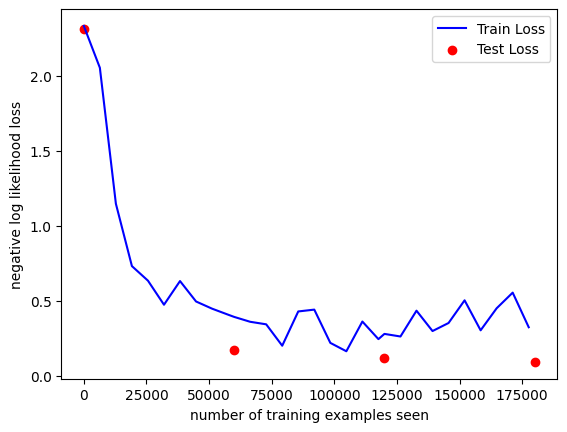

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

We get most of the training done right at the start, but going from 20% to 80% accuracy is easy. The closer we get to 100%, the harder it is to get additional accuracy.


Let's take a look at some examples:

In [ ]:
with torch.no_grad():
  output = network(example_data.to(device))

<ipython-input-6-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


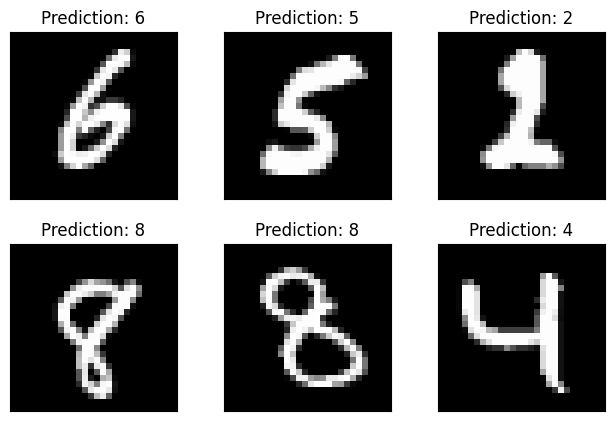

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

The model guesses the numbers correctly! Let's see the accuracy for each number:

In [ ]:
classes = [str(i) for i in range(11)]
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

<ipython-input-6-fe54d3ae7723>:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 97 %
Accuracy of     5 : 95 %
Accuracy of     6 : 98 %
Accuracy of     7 : 96 %
Accuracy of     8 : 95 %
Accuracy of     9 : 95 %


**Question 3:** Which numbers have the worst accuracy? Can you guess why? Knowing the accuracy of the model is about 97%, would you say this is comparable to human-level accuracy for the same task?

Type your answer here.
Brojevi 5,8 i 9 imaju najmanju točnost. To je zato jer su brojevi pisani ručno, a znamo da postoji puno različitih rukopisa koji mogu biti neuredni te razlika između tih brojeva na prvu može biti jako mala. Točnost ovog modela vjerojatno nije na razini točnnosti čovjeka za ovaj problem, iako bi se u podatkovnom skupu sigurno našlo primjere koji bi i ljudima stvarali problem u prepoznavanju.

In [ ]:
Ne zaboravite spremiti zadatke na GitHub!